In [1]:
import numpy as np
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import ode
from scipy import interpolate
import pickle

import os
import time

In [2]:
Ipath = "IforRealNeuron.csv"
Idat = np.genfromtxt(Ipath, delimiter=',')

#Ipath = "NaKL_stim_dt0p02_N6001.npy"
#Idat = np.load(Ipath)
#Idat[:,1] = Idat[:,1] - np.min(Idat[:,1])
#Idat[:,1] = np.multiply(Idat[:,1], 5 / np.max(Idat[:,1]))

Idat = np.load("L96x0.npy")
Idat = np.multiply(Idat, 5 / np.max(Idat))

<IPython.core.display.Javascript object>


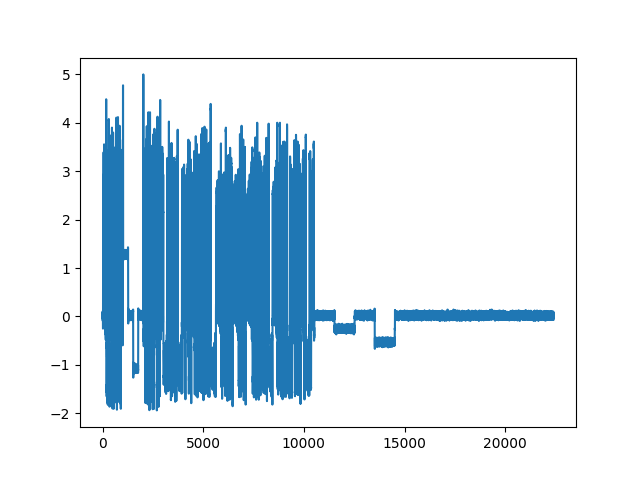

In [3]:
plt.plot(Idat)
plt.show()

In [4]:
#Scaling Values
# The scale for V * C should match the scale for I
V_scale = 1 # V to mV
C_scale = 1e9 # F to pF

# The scales for I * R should match the scale for V
I_scale = 1e9 # A to fA
R_scale = 1e-9 # O to ...

In [5]:
# Voltages
# Chip bias voltage
V_ref = 1 * V_scale
# Unit Volt(?)
V_unit = 26e-3 * V_scale

# Currents
# Master current(?)
I_master = 1.25e-9 * I_scale
# Voltage(?)
I_voltage = 230e-9 * I_scale
# Reference Current(?)
I_ref = 85e-9 * I_scale
# Injected current scale factor
I_inj_scale = (0.018) * 1e-9 * I_scale

# Capacitances
# Membrane Capacitance
C_m = 4e-12 * C_scale
# Gate capacitance
C_gate = 5e-12 * C_scale

# Resistances
Res = 1.63e6 * R_scale
R_bias = 1.85e6  * R_scale
R_factor = 700e3 * R_scale
R_factor2 = 50e3 * R_scale

# Scale Factors
kappa = 0.7

# Hodgkin Huxley Parameters
g0 = [800, 160, 15] #maximal conductances
e_rev = [300, -210, -190] #reversal potentials in mV

# Scaling H-H parameters for chip
g = np.multiply(g0,(kappa / V_unit) * (I_master / 1024))
E_rev = np.multiply(e_rev,(I_voltage / 1024) * Res) + V_ref


# Conductance Dynamics
vBias = np.zeros(7)
vHigh = V_ref + R_bias * I_voltage
vLow = V_ref - R_bias * I_voltage
I_factor = (vHigh - vLow) / R_factor
vBias[0] = vLow + I_factor * R_factor2

for i in xrange(1,7):
    #[635.2, 756.8, 878.42, 1000, 1121.57, 1243.14, 1364.7] in mV
    vBias[i] = vBias[i - 1] + I_factor * 2*R_factor2 
    
g_f = 1 / (C_gate * V_unit)


In [6]:
am = np.array([0, 0, 120, 400, 800, 1023, 1023]) * I_master / 1024 * g_f
bm = np.array([1023, 1023, 1023, 1023, 0, 0, 0]) * I_master / 1024 * g_f

ah = np.array([237, 80, 0, 0, 0, 0, 0]) * I_master / 1024 * g_f 
bh = np.array([0, 0, 0, 0, 41, 50, 70]) * I_master / 1024 * g_f

an = np.array([0, 0, 0, 0, 18, 5, 43]) * I_master / 1024 * g_f
bn = np.array([1, 0, 0, 1, 0, 0, 1]) * I_master / 1024 * g_f

### Save parameters for later use

In [7]:
model_params = []
model_params.append(g)
model_params.append(E_rev)
model_params.append(vBias)
model_params.append(am)
model_params.append(bm)
model_params.append(ah)
model_params.append(bh)
model_params.append(an)
model_params.append(bn)

with open("model_parameters/model_params.txt", "wb") as fp:
    pickle.dump(model_params ,fp)

scale_factors = np.array([V_scale, C_scale, I_scale, I_inj_scale, R_scale])
np.save('model_parameters/scale_factors.npy', scale_factors)

In [8]:
def sigma(vBiask, V, sign = 1):
    mu = 0.7
    Ut = 26e-3 * V_scale
    return 1 / (1 + np.exp(sign * mu * (vBiask - V) / Ut))



def alpha_spline(V, x, vBias=vBias, am=am, ah=ah, an=an):
    """
    Used to compute the conductance at each time point. 
    The optional arguments default to the parameters defined at the start of the document
    """
    alpha = 0
    for k in np.arange(7):
        if x == "m":
            alpha += am[k] * sigma(vBias[k], V, 1)
        if x == "h":
            alpha += ah[k] * sigma(vBias[k], V, -1)
        if x == "n":
            alpha += an[k] * sigma(vBias[k], V, 1)
    return alpha #* I_master / 1024 * g_f


def beta_spline(V, x, vBias=vBias, bm=bm, bh=bh, bn=bn):
    beta = 0
    for k in np.arange(7):
        if x == "m":
            beta += bm[k] * sigma(vBias[k], V, -1)
        if x == "h":
            beta += bh[k] * sigma(vBias[k], V, 1)
        if x == "n":
            beta += bn[k] * sigma(vBias[k], V, -1)
    return beta #* I_master / 1024 * g_f


Here we define our system as well as the injected current

In [11]:
fIdat = interpolate.interp1d(np.arange(0,len(Idat)), Idat) #Used to interpolate time points that are undefined in Idat
#fIdat = interpolate.interp1d(Idat[:,0], Idat[:,1]) #Used to interpolate time points that are undefined in Idat

sample_rate = 5e3
def I_inj(t, scale=I_inj_scale):
    if t * sample_rate <= len(Idat):
        return fIdat(t * sample_rate) * scale
    else:
        print("t is outside of interpolation range")
        return 0


def neuron(y, t):
    v, m, h, n = y
    # g = (2.62e-5, 5.25e-6, 4.9e-7)
    # E_rev = (1109, 923, 930.4)
    I_na = g[0] * m**3 * h * (E_rev[0] - v)
    I_k = g[1] * n**4 * (E_rev[1] - v)
    I_l = g[2] * (E_rev[2] - v)
    
    dvdt = (I_inj(t) + I_na + I_l + I_k) / C_m
    dmdt = alpha_spline(v, "m") * (1 - m) - beta_spline(v, "m") * m
    dhdt = alpha_spline(v, "h") * (1 - h) - beta_spline(v, "h") * h
    dndt = alpha_spline(v, "n") * (1 - n) - beta_spline(v, "n") * n
    
    dydt = [dvdt, dmdt, dhdt, dndt]

    return dydt



We set the initial conditions and time window

In [12]:
y0 = [1.09 * V_scale, 0.5 * I_scale / (V_scale * C_scale), 
      0.5 * I_scale / (V_scale * C_scale), 0.5 * I_scale / (V_scale * C_scale)] #initial conditions
t_step = 1e-3
t_max = 4
t = np.linspace(0, t_max, int(t_max / t_step + 1))

start_time = time.time()

sol = odeint(neuron, y0, t, args=())
print "Time elapsed:", time.time() - start_time

Time elapsed: 177.571478128


Plot the data

<IPython.core.display.Javascript object>


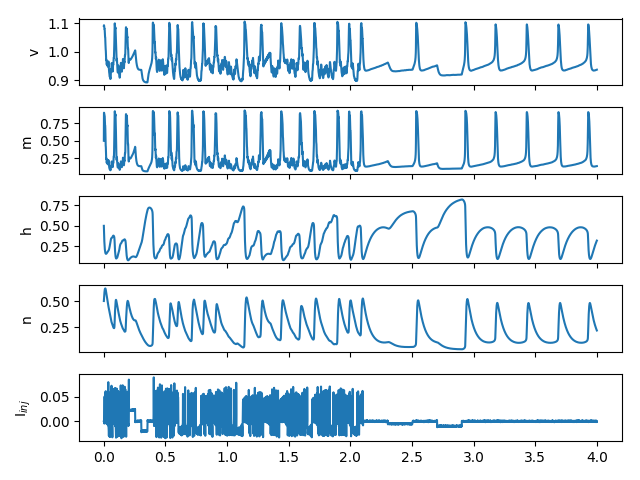

In [33]:
fig, ax = plt.subplots(5,1, sharex=True)
fig.set_tight_layout(True)

ax[0].plot(t, sol[:,0])
ax[0].set_ylabel('v')

ax[1].plot(t, sol[:,1])
ax[1].set_ylabel('m')

ax[2].plot(t, sol[:,2])
ax[2].set_ylabel('h')

ax[3].plot(t, sol[:,3])
ax[3].set_ylabel('n')

ax[4].plot(t, np.vectorize(I_inj)(t))
ax[4].set_ylabel('I$_{inj}$')

plt.savefig("results/ode_data.png")
plt.show()


### Add noise

<IPython.core.display.Javascript object>


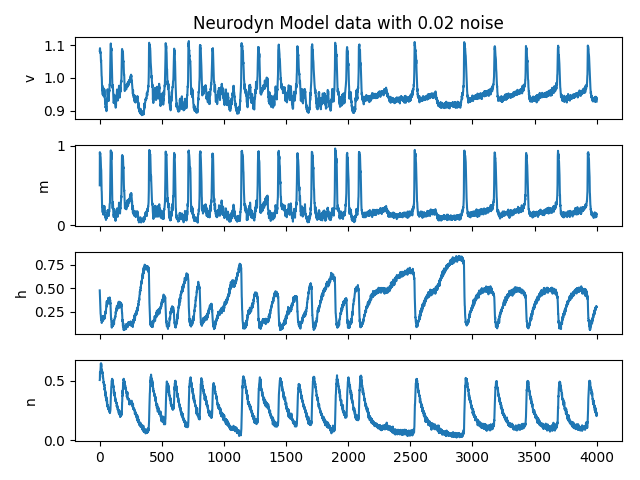

In [46]:
noise_level = 0.02
noisy_sol = np.empty_like(sol)

for i in xrange(sol.shape[1]):
    # get the range of the solution
    d_range = max(sol[:,i]) - min(sol[:,i])
    noise = np.random.normal(scale=noise_level*d_range, size=sol.shape[0])
    noisy_sol[:,i] = sol[:,i] + noise

fig, ax = plt.subplots(4,1, sharex=True)
labels = ["v", "m", "h", "n"]
fig.set_tight_layout(True)
ax[0].set_title("Neurodyn Model data with %0.2f noise" % (noise_level))
for i in xrange(noisy_sol.shape[1]):
    ax[i].plot(noisy_sol[:,i])
    ax[i].set_ylabel(labels[i])
plt.show()

Save data

In [47]:
# add time to data
data = np.insert(sol, 0, t, axis=1)
# add injected current at each time step to data
data = np.insert(data, data.shape[1], fIdat(t * sample_rate), axis=1)
# change shape such that time steps are rows
data = data.reshape(len(t),6)
np.save('results/ode_data.npy', data)

noisy_data = np.insert(sol, 0, t, axis=1)
noisy_data = np.insert(data, data.shape[1], fIdat(t * sample_rate), axis=1)
noisy_data = data.reshape(len(t),6)
np.save('results/noisy_ode_data.npy', noisy_data)